##Installing Libraries(if require)

In [ ]:
#!pip install keras-resnet
#!pip install h5py pyyaml

##Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from urllib.request import urlopen,urlretrieve
from PIL import Image
from tqdm import tqdm_notebook
%matplotlib inline
from sklearn.utils import shuffle


from tensorflow.keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from tensorflow.keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

Mounting google drive and datasetpath directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
trainpath = 'drive/My Drive/ColabDatasets/chest_xray/train'
testpath = 'drive/My Drive/ColabDatasets/chest_xray/test'

Mounted at /content/drive


Concatination of img dir with img labels

In [ ]:
types = os.listdir(trainpath)
TrainImgDir = []
for type in types:
  Atypegroup = os.listdir(trainpath+'/'+type)
  for imgdir in Atypegroup:
    TrainImgDir.append((type,str(trainpath+'/'+type+'/')+imgdir))


In [ ]:
tetypes = os.listdir(testpath)
TestImgDir = []
for type in tetypes:
  Atypegroup = os.listdir(testpath+'/'+type)
  for imgdir in Atypegroup:
    TestImgDir.append((type,str(testpath+'/'+type+'/')+imgdir))
 

Building DataFrame(Test,Train,Valid)

In [ ]:
DF = pd.DataFrame(data=TrainImgDir,columns=['ImgType','ImgDir'],index=None)

from sklearn.model_selection import train_test_split

TrainDF, validDF = train_test_split(DF, test_size=0.1)
TrainDF = shuffle(TrainDF)
TrainDF.head()




,ImgType,ImgDir
4147,NORMAL,drive/My Drive/ColabDatasets/chest_xray/train/...
4055,NORMAL,drive/My Drive/ColabDatasets/chest_xray/train/...
4330,NORMAL,drive/My Drive/ColabDatasets/chest_xray/train/...
2959,PNEUMONIA,drive/My Drive/ColabDatasets/chest_xray/train/...
4627,NORMAL,drive/My Drive/ColabDatasets/chest_xray/train/...


In [ ]:
TestDF = pd.DataFrame(data=TestImgDir,columns=['ImgType','ImgDir'],index=None)
TestDF.head()


,ImgType,ImgDir
0,NORMAL,drive/My Drive/ColabDatasets/chest_xray/test/N...
1,NORMAL,drive/My Drive/ColabDatasets/chest_xray/test/N...
2,NORMAL,drive/My Drive/ColabDatasets/chest_xray/test/N...
3,NORMAL,drive/My Drive/ColabDatasets/chest_xray/test/N...
4,NORMAL,drive/My Drive/ColabDatasets/chest_xray/test/N...


Just Printing no of images in subsets and each category

In [ ]:

print('Total no of training images in dataset:',len(TrainDF))
print('No of images in each category')
print(TrainDF['ImgType'].value_counts())

Total no of training images in dataset: 4709
No of images in each category
PNEUMONIA    3508
NORMAL       1201
Name: ImgType, dtype: int64


In [ ]:
print('Total no of testing images in dataset:',len(TestDF))
print('No of images in each category')
print(TestDF['ImgType'].value_counts())

Total no of testing images in dataset: 624
No of images in each category
PNEUMONIA    390
NORMAL       234
Name: ImgType, dtype: int64


In [ ]:
print('Total no of validation images in dataset:',len(validDF))
print('No of images in each category')
print(validDF['ImgType'].value_counts())

Total no of validation images in dataset: 524
No of images in each category
PNEUMONIA    376
NORMAL       148
Name: ImgType, dtype: int64


Image Reading & Resizing

In [ ]:
TrainImages=[]
TrainLabels=[]
for index, row in TrainDF.iterrows():
  #Img read
  Img = cv2.imread(row['ImgDir'])
  try:
    #Img Resize
    ImgRe = cv2.resize(Img,(224,224), interpolation=cv2.INTER_AREA)
    TrainImages.append(ImgRe)
    TrainLabels.append(row['ImgType'])
  except:
    continue
  
print(len(TrainLabels))
print(len(TrainImages))
TrainImages = np.array(TrainImages)
TrainImages = TrainImages.astype('float32')/255.0


4708
4708


In [ ]:
validImages=[]
validLabels=[]
for index, row in validDF.iterrows():
  #Img read
  Img = cv2.imread(row['ImgDir'])
  try:
    #Img Resize
    ImgRe = cv2.resize(Img,(224,224), interpolation=cv2.INTER_AREA)
    validImages.append(ImgRe)
    validLabels.append(row['ImgType'])
  except:
    continue
  
print(len(validLabels))
print(len(validImages))
validImages = np.array(validImages)
validImages = validImages.astype('float32')/255.0


524
524


In [ ]:
TestImages=[]
TestLabels=[]
for index, row in TestDF.iterrows():
  #Img read
  Img = cv2.imread(row['ImgDir'])
  try:
    #Img Resize
    ImgRe = cv2.resize(Img,(224,224), interpolation=cv2.INTER_AREA)
    TestImages.append(ImgRe)
    TestLabels.append(row['ImgType'])
  except:
    continue
  
print(len(TestLabels))
print(len(TestImages))
TestImages = np.array(TestImages)
TestImages = TestImages.astype('float32')/255.0

624
624


Transform Labels into Categorical Y

In [ ]:
Ytrain = TrainLabels
LabelEnc = LabelEncoder()
Ytrain = LabelEnc.fit_transform(Ytrain)


Ytrain = Ytrain.reshape(-1,1)

ct = ColumnTransformer([("ImgType", OneHotEncoder(), [0])], remainder = 'passthrough')
Ytrain = ct.fit_transform(Ytrain)
print(Ytrain[0])
print(Ytrain.shape)

[1. 0.]
(4708, 2)


In [ ]:
Ytest = TestLabels
LabelEnc = LabelEncoder()
Ytest = LabelEnc.fit_transform(Ytest)


Ytest = Ytest.reshape(-1,1)

ct = ColumnTransformer([("ImgType", OneHotEncoder(), [0])], remainder = 'passthrough')
Ytest = ct.fit_transform(Ytest)
print(Ytest[0])
print(Ytest.shape)

[1. 0.]
(624, 2)


In [ ]:
Yvalid = validLabels
LabelEnc = LabelEncoder()
Yvalid = LabelEnc.fit_transform(Yvalid)


Yvalid = Yvalid.reshape(-1,1)

ct = ColumnTransformer([("ImgType", OneHotEncoder(), [0])], remainder = 'passthrough')
Yvalid = ct.fit_transform(Yvalid)
print(Yvalid[0])
print(Yvalid.shape)

[0. 1.]
(524, 2)


##ResNet base model(loading)

In [ ]:
img_height,img_width = 224,224 
num_classes = 2
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


##Training Model(ResNet)

In [ ]:
r = model.fit(TrainImages, Ytrain,validation_data=(validImages,Yvalid), epochs = 10, batch_size = 12)

Epoch 1/10
393/393 [==============================] - 167s 327ms/step - loss: 0.5492 - accuracy: 0.8369 - val_loss: 5.2917 - val_accuracy: 0.8053
Epoch 2/10
393/393 [==============================] - 125s 319ms/step - loss: 0.3372 - accuracy: 0.8925 - val_loss: 0.5670 - val_accuracy: 0.6966
Epoch 3/10
393/393 [==============================] - 125s 318ms/step - loss: 0.2465 - accuracy: 0.9212 - val_loss: 2.7405 - val_accuracy: 0.3187
Epoch 4/10
393/393 [==============================] - 125s 318ms/step - loss: 0.1965 - accuracy: 0.9350 - val_loss: 0.2560 - val_accuracy: 0.9008
Epoch 5/10
393/393 [==============================] - 125s 318ms/step - loss: 0.1516 - accuracy: 0.9473 - val_loss: 0.0882 - val_accuracy: 0.9676
Epoch 6/10
393/393 [==============================] - 126s 320ms/step - loss: 0.1499 - accuracy: 0.9501 - val_loss: 0.0984 - val_accuracy: 0.9599
Epoch 7/10
393/393 [==============================] - 125s 319ms/step - loss: 0.0990 - accuracy: 0.9641 - val_loss: 0.1058 -

##Accuray(ResNet)

In [ ]:
preds = model.evaluate(TestImages, Ytest)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

20/20 [==============================] - 6s 245ms/step - loss: 0.8156 - accuracy: 0.8013
Loss = 0.8156483769416809
Test Accuracy = 0.8012820482254028


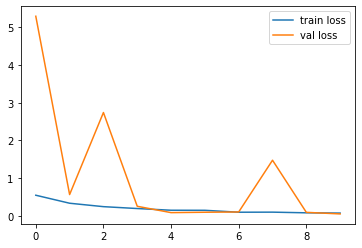

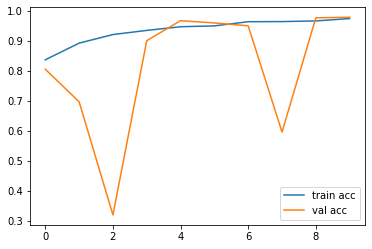

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

##Saving Model ResNet50

In [ ]:
model.save('ChestXrayResnet.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model('ChestXrayResnet.h5') #same file path

In [ ]:
loss, acc = new_model.evaluate(TestImages, Ytest, verbose=0)
print(f"test accuracy {acc*100}")

test accuracy 80.12820482254028


In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

##VGG16 base model (Loading)

In [ ]:
!pip install keras.applications

     |████████████████████████████████| 50 kB 4.5 MB/s 


In [ ]:
from keras.applications.vgg16 import VGG16
img_height,img_width = 224,224 
num_classes = 2

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height,img_width, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Freeze four convolution blocks
for layer in vgg_model.layers[:15]:
    layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x) # Softmax for multiclass
transfer_model = Model(inputs=vgg_model.input, outputs=x)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint = ModelCheckpoint('vgg16_finetune.h15', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

##Training VGG16

In [ ]:
learning_rate= 5e-5
transfer_model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate), metrics=["accuracy"])
r = transfer_model.fit(TrainImages, Ytrain,validation_data=(validImages,Yvalid), batch_size = 12, epochs=10, callbacks=[lr_reduce,checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
393/393 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.9556
Epoch 00001: val_accuracy improved from -inf to 0.97328, saving model to vgg16_finetune.h15
INFO:tensorflow:Assets written to: vgg16_finetune.h15/assets
393/393 [==============================] - 111s 195ms/step - loss: 0.1219 - accuracy: 0.9556 - val_loss: 0.0632 - val_accuracy: 0.9733 - lr: 5.0000e-05
Epoch 2/10
393/393 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9834
Epoch 00002: val_accuracy did not improve from 0.97328
393/393 [==============================] - 62s 159ms/step - loss: 0.0490 - accuracy: 0.9834 - val_loss: 0.0765 - val_accuracy: 0.9695 - lr: 5.0000e-05
Epoch 3/10
393/393 [==============================] - ETA: 0s - loss: 0.0393 - accuracy: 0.9860
Epoch 00003: val_accuracy improved from 0.97328 to 0.97901, saving model to vgg16_finetune.h15
INFO:tensorflow:Assets written to: vgg16_finetune.h15/assets
393/393 [==============================] - 70

##Accuracy VGG16

In [ ]:
preds = transfer_model.evaluate(TestImages, Ytest)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

20/20 [==============================] - 19s 487ms/step - loss: 0.7982 - accuracy: 0.8510
Loss = 0.7981559634208679
Test Accuracy = 0.8509615659713745


Line Graph

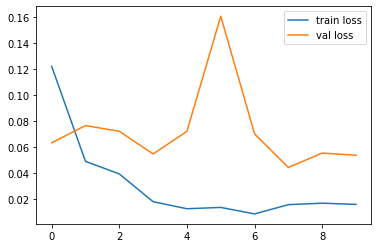

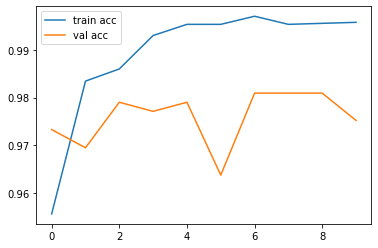

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('vggAccVal_acc')

In [ ]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

##Saving Model VGG16

In [ ]:
transfer_model.save('ChestXrayVGGnet.h5')

In [ ]:
import tensorflow as tf

new_model = tf.keras.models.load_model('ChestXrayVGGnet.h5') #same file path

OSError: ignored

In [ ]:
loss, acc = new_model.evaluate(TestImages, Ytest, verbose=0)
print(f"test accuracy {acc*100}")

test accuracy 85.09615659713745


In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
pred = new_model.predict(TestImages[:6])